# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from fa2 import ForceAtlas2
import numpy as np
import csv
import networkx as nx
import os
#couchsurfing API is external API locally saved also available in our github: https://github.com/eikekutz/SocialGraphFinalProject
from couchsurfing import Api
from random import randint
from time import sleep
from geopy import geocoders
import unidecode
import conda
import pickle

#Necessary Settings for the conda package to work with the Basemap if it gives errors
# - if you are missing Basemap package, just please execute: conda install -c conda-forge basemap

# - if it still doesn't work try to uncomment lines below:

#conda_file_dir = conda.__file__
#conda_dir = conda_file_dir.split('lib')[0]
#proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
#os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap


 * **0\. Data Extraction**
    * 0.1\. Couchsurfing API Data Gathering
        * 0.1.1\. Get Hosts Data
        * 0.1.2\. Get Reviews and Reviewers Data
    * 0.2\. Data Merging
    * 0.3\. Adding Geo Location of Users
    * 0.4\. Cleaning Data
    
* 1\. Project's objective (**fix list problem**)
    * 1.1\. What do we want to answer in this project
    * 1.2\. Datasets limitations
    
* **2\. Preliminary Data Analysis**
    * 2.1\. User
        * 2.1.1\. User Analysis
        * 2.1.2\. User Statistics
        * 2.1.3\. User Graphs
    * 2.2\. City
        * 2.2.1\. City Clustering
        * 2.2.2\. City Analysis
        * 2.2.3\. City Statistics
        * 2.2.4\. City Graphs

* **3\. Network Construction**
    * 3.1\.User 
        * 3.1.1\. Initial Analysis
    * 3.2\.City 
        * 3.2.1\. Initial Analysis

* **4\. Basic Network Analysis**
    * 4.1\. Degree Distribution
    * 4.2\. Power-laws and Friendship Paradox
    * 4.3\. Centrality
    * 4.4\. Assortativity
    * 4.5\. Modularity and Communities
    * 4.6\. Network Visualizations and Statistics

* **5\. Analysis of Review data**
    * 5.1\. Wordclouds
    * 5.2\. Happiness Averages
        * 5.2.1\. Users
        * 5.2.2\. Cities

* **6\. Analysis of specific Users**
    * 6.1\. Get Profile Data
    * 6.2\. Combined sentiment
        * 6.1.1\. Overall/Host/Surfer -Review
        * 6.1.1\. Image Sentiment
        * 6.1.1\. Profile description Sentiment ( 
    * 6.2\. Best/Worst User
        * 6.2.1\. Best/Worst Couchsurfer
        * 6.2.1\. Best Host

* **7\. Discussion**

# 0.Data Extraction#

In [2]:
def getHostFromCity(city,latitude,longitude):
    '''
    getting all the host data within a circle with a radius of 25km 
    max 20 pages with each 100 users
    '''
    print("Getting results for ",city,latitude,longitude)
    for p in range(1,20):
        print(p)
        ##hosts = api.get_hosts(city,25,100,p)
        ##hosts = api.get_hosts(city,25,100,None,'best_match',"yes,maybe",None,p,last_login)
        hosts = api.get_hosts_latlong(latitude,longitude,p,100,25,4)
        writeCityResults2File(hosts,city,p)
        sleep(randint(2,5))

In [3]:
def writeCityResults2File(results,cityString,page):
    '''
    writing hosts to csv file 100 users for each file
    '''
    with open('data/Top50/hosts/'+cityString+str(page)+'.csv','w',newline="") as f:
        writer = csv.writer(f,delimiter = ',')
        # Write CSV Header, If you dont need that, remove this line
        writer.writerow(["id",
                "publicName",
                "avatarUrl",
                "isVerified",
                "status",
                "lastLogin",
                "aboutText",
                "responseRate",
                "responseTimeText",
                'responseRateText',
                "totalReferencesCount",
                "profileLink",
                "friendsCount",
                "languages",
                "city"])

        for host in results['results']:
            writer.writerow([host["id"],
                    host["publicName"],
                    host["avatarUrl"],
                    host["isVerified"],
                    host["status"],
                    host["lastLogin"],
                    host["aboutText"],
                    host["responseRate"],
                    host["responseTimeText"],
                    host["responseRateText"],
                    host["totalReferencesCount"],
                    host["profileLink"],
                    host["friendsCount"],
                    host["languages"],
                    cityString])

In [2]:
#import nodes to get id from nodes/hosts
def importHosts(index):
    '''
    Import merged hosts to get id, which is used to download the reviews for each user
    '''
    hosts = pd.DataFrame() #creates a new dataframe that's empty
    city = cities.loc[index]
    for p in range(1,15):
        if (os.path.exists('data/Top50/hosts/'+city['name']+str(p)+'.csv')):
            df = pd.read_csv('data/Top50/hosts/'+city['name']+str(p)+'.csv')
            hosts = pd.concat([hosts,df]).reset_index(drop=True)
    return hosts

In [3]:
def createRevCityList(city): 
    '''
    Create a csv file for the given city to store reviews of the city
    '''
    with open('data/Top50/reviews/'+city+'Rev.csv','w',newline="") as f:
            writer = csv.writer(f,delimiter = ',')
            writer.writerow(["id",
                    "text",
                    "createdDate",
                    "experience",
                    "relationshipType",
                    "isPostTrip",
                    "to",
                    "from",
                    "fromPublicName",
                    "fromPublicAddressId",
                    "fromPublicAddressDescription",
                    "fromAvatarUrl",
                    "fromStatus",
                    "fromIsVerified",
                    "fromIsDeleted",
                    "fromBlockedBy",
                    "inverseReference",
                    "response"])

In [4]:
def appendReview(file,city):
    '''
    Append Reviews of the user on the specific city reviews csv file
    '''
    with open('data/Top50/reviews/'+city+'Rev.csv','a',newline="") as f:
        writer = csv.writer(f,delimiter = ',')
        for host in file['results']:
            writer.writerow([host["id"],
                host["text"],
                host["createdDate"],
                host["experience"],
                host["relationshipType"],
                host["isPostTrip"],
                host["to"]['id'],
                host["from"]['id'],
                host["from"]["publicName"],
                host["from"]["publicAddress"]["id"],
                host["from"]["publicAddress"]["description"],
                host["from"]["avatarUrl"],
                host["from"]["status"],
                host["from"]["isVerified"],
                host["from"]["isDeleted"],
                host["from"]["blockedBy"],
                host["inverseReference"],
                host["response"]])

In [5]:
def getReferenceForCity(index):
    '''
    Get the reviews for every hosts for a given city based on the downloaded host dataset
    '''
    hosts= importHosts(index=index)
    city = cities.loc[index]
    print("Getting results for ",city['name'])
    createRevCityList(city['name'])
    for idx,host in hosts.iterrows():
        test=api.get_references(uid=host['id'],type='host')
        appendReview(test,city['name'])
        test=api.get_references(uid=host['id'],type='surf')
        appendReview(test,city['name'])     

## 0.1. Couchsurfing API Data Gathering

In [ ]:
#Get all the hosts from a city , iterating over the city list
for idx,city in cities.iterrows():#.loc[cities['2017']>50000].iterrows():
    getHostFromCity(city['name'],city['lat'],city['lng'])
    sleep(randint(10,20))

In [ ]:
#Getting the references for all the hosts
for idx,city in cities.iterrows():#.loc[cities['2017']>50000].iterrows():
    if idx>10:
        getReferenceForCity(idx)
        sleep(randint(5,10))

## 0.2. Data Merging



In [2]:
#Merging host's data
cities = pd.read_csv('data/Top50/top50cities.csv',delimiter=',')
hosts = pd.DataFrame() #creates a new dataframe that's empty
for idx,city in cities.iterrows():#.loc[cities['2017']>50000].iterrows():
    for p in range(1,14):
        if (os.path.exists('data/Top50/hosts/'+city['name']+str(p)+'.csv')):
            df = pd.read_csv('data/Top50/hosts/'+city['name']+str(p)+'.csv',index_col=False,dtype={'id': np.int64})
            hosts = pd.concat([hosts,df]).reset_index(drop=True)
hosts=hosts.drop_duplicates()

In [3]:
print(len(hosts))

10582


In [4]:
#merging review data
rev = pd.DataFrame() #creates a new dataframe that's empty
for idx,city in cities.iterrows():#.loc[cities['2017']>50000].iterrows():
    if os.path.exists('data/Top50/reviews/'+city['name']+'Rev.csv'):
        df = pd.read_csv('data/Top50/reviews/'+city['name']+'Rev.csv',index_col=False)
        rev = pd.concat([rev,df]).reset_index(drop=True)
rev=rev.drop_duplicates()

In [5]:
#adding sentiment analysis of the reviews
# load data from pickle
sentiment_per_review_dict = pickle.load( open( 'data/Top50/reviews/Pickles/SentimentPerReview_Dict.pickle', "rb" ) )
# map values from dictionary into dataframe by rev_id
rev['sentimentValue'] = rev['id'].map(sentiment_per_review_dict)

print(list(sentiment_per_review_dict.values()).count(None),' of ',len(list(sentiment_per_review_dict)), 'has been ommited due to the lack of sentiment')
                                    

9021  of  96085 has been ommited due to the lack of sentiment


In [43]:
# create multigraph 
G_withSentValue = nx.MultiDiGraph()

# filter out reviews from these that don't have sentiment value
couchserfing_reviews = rev.loc[ rev['sentimentValue'].notnull()]

#append edges to the multigraph
couchserfing_reviews=couchserfing_reviews.rename(columns = {'sentimentValue':'weight'})
G_withSentValue = nx.from_pandas_dataframe(couchserfing_reviews, 'from', 'to', edge_attr=['weight','relationshipType'], create_using=nx.MultiDiGraph())
couchserfing_reviews=couchserfing_reviews.rename(columns = {'weight':'sentimentValue'})

# todo: filter nodes without connection abour 10000
G_withSentValue.add_nodes_from([(rows['id'],{'city':rows['city']}) for idx,rows in hosts.iterrows()])

print(len(G_withSentValue.nodes))
print(len(G_withSentValue.edges))
#test
#print(len(G_withSentValue.edges))
#(len(couchserfing_reviews))

83052
87064


In [7]:
#creatdiGraph to see how many edges will be overriten calculation of re-visites
G = nx.DiGraph()

G.add_nodes_from([(rows['id'],{'city':rows['city']}) for idx,rows in hosts.iterrows()])

G = nx.from_pandas_dataframe(couchserfing_reviews, 'from', 'to')


In [8]:
print(G_withSentValue[2009059021][2001999679])
print(G_withSentValue[2009059021][2007724821])
rev.head(2)

{0: {'weight': 6.768571428571428, 'relationshipType': 'host'}}
{0: {'weight': 6.403125000000003, 'relationshipType': 'surf'}}


,id,text,createdDate,experience,relationshipType,isPostTrip,to,from,fromPublicName,fromPublicAddressId,fromPublicAddressDescription,fromAvatarUrl,fromStatus,fromIsVerified,fromIsDeleted,fromBlockedBy,inverseReference,response,sentimentValue
0,27077307,Amazing chef and humble human being. Willing t...,2018-10-17T22:09:22Z,positive,host,True,2009059021,2001999679,Dhanush Anand,109610804.0,"Setiabudi, Jakarta, Indonesia",https://s3.amazonaws.com/ht-images.couchsurfin...,yes,True,False,NaN,NaN,NaN,6.76857
1,27152728,Amazing boy with amazing family . He met me up...,2018-10-28T19:16:31Z,positive,surf,True,2009059021,2007724821,Bakhar Sardzhaeva,271153483.0,Dubai,https://s3.amazonaws.com/ht-images.couchsurfin...,no,False,False,NaN,NaN,NaN,6.40313


In [46]:
#print(G_withSentValue[2009059021][2007724821])

nx.get_node_attributes(G_withSentValue,'city')

{2009059021: 'Moscow',
 2008295707: 'Moscow',
 2009276730: 'Moscow',
 2007438797: 'Moscow',
 2009017440: 'Moscow',
 2008873184: 'Moscow',
 1001118581: 'Budapest',
 2003698502: 'Moscow',
 2004079282: 'Budapest',
 2005423146: 'Moscow',
 2008461429: 'Moscow',
 2007897688: 'Moscow',
 1005318661: 'Moscow',
 2002963430: 'Moscow',
 2007156292: 'Moscow',
 2008406713: 'St Petersburg',
 2007603705: 'Moscow',
 2008732238: 'Moscow',
 2008182963: 'Moscow',
 1000754645: 'Moscow',
 2003021439: 'Moscow',
 4308983: 'Moscow',
 3531747: 'Moscow',
 2000854741: 'Moscow',
 4973903: 'Moscow',
 2008478484: 'Moscow',
 2009179593: 'Moscow',
 2009063624: 'Moscow',
 2007416721: 'Moscow',
 4935233: 'Moscow',
 2000928283: 'Milan',
 1004240822: 'St Petersburg',
 2005146189: 'Moscow',
 1000111175: 'Minsk',
 2007169164: 'Moscow',
 4196062: 'Moscow',
 2008850446: 'Moscow',
 2008606300: 'Moscow',
 2006253648: 'Moscow',
 2006551502: 'Moscow',
 1003073305: 'Kyiv',
 2006558767: 'Moscow',
 3918396: 'Moscow',
 2000356014: 'B

## 0.3. Adding Geo Location of Users



In [ ]:
cities_not_found = []
def getCityCoords(name):
    gn = geocoders.GeoNames(username='kacper')
    try:
        loc = gn.geocode(name, timeout=10)
        if loc is None:
            try: 
                loc =gn.geocode(name.split(',')[0],timeout=10)
                if loc is None:
                    raise TypeError
            except Exception as inst:
                print('This city was not found:',name)
                return None
    except Exception as inst:
        print('This city was not found:',name)
        cities_not_found.append(name)
        return None
    #print(len(loc))
   # print(loc[0].raw)
    return loc

In [ ]:
#source: https://www.maxmind.com/en/free-world-cities-database
worldCities = pd.read_csv('../worldcitiespop.txt',encoding = "ISO-8859-1")
#source: https://datahub.io/core/country-list#resource-data
cc= pd.read_csv('data/country_map.txt')

In [15]:
#Example how the data look like:
print('Number of entries worldCitiespop.txt: ',len(worldCities))
worldCities.head(3)

Number of entries worldCitiespop.txt:  3173958


,Country,City,AccentCity,Region,Population,Latitude,Longitude
0,ad,aixas,Aixàs,6,NaN,42.483333,1.466667
1,ad,aixirivali,Aixirivali,6,NaN,42.466667,1.500000
2,ad,aixirivall,Aixirivall,6,NaN,42.466667,1.500000


In [ ]:

uniqueCities=rev.fromPublicAddressDescription.unique()
uniqueCities = uniqueCities.tolist()

In this Part we map a geographical position to every review.
With this information we know the reviewer geographical position.
Due to the high number of reviewer's unique locations and the geopy API's limitation of 5000 requests a day we used the worldcitiespop.txt.
If an entry couldn't be found in this list we used the geopy API to supplement the missing entries.
If a review's location couldn't be found it will be droppend afterwards.
The nummber of not found location is 815 out of 96085 with is a 0.848% of the reviews data.

In [4]:
exList=["nan"]
for city in unique:
    if all([c[1]=='NaN'for c in rev.loc[rev.fromPublicAddressDescription==city]['lat'].iteritems()]):
        if str(city).lower() not in exList:
            #Search for entry in the worldcities list and map with country code (cc) if necessary
            loc = worldCities.loc[worldCities.City==city.split(',')[0].lower().strip()]
            if len(loc.index)>1:
                try:
                    countryCode = cc.loc[cc.Name==city.split(',')[-1].strip().lower().title()]['Code'].values[0]
                    loc =loc.loc[loc.Country==countryCode.lower()].head(1)
                except:
                    loc=loc.head(1)
            if len(loc.head(1).index)==0:
                c=test=unidecode.unidecode(city)
                loc = worldCities.loc[worldCities.City==c.split(',')[0].lower().strip()].head(1)
                if len(loc.index)>1:
                    try:
                        countryCode = cc.loc[cc.Name==c.split(',')[-1].strip().lower().title()]['Code'].values[0]
                        loc =loc.loc[loc.Country==countryCode.lower()].head(1)
                    except:
                        loc=loc.head(1)  

            if len(loc.head(1).index)==1:
                l=rev.loc[rev.fromPublicAddressDescription==city].index.tolist()
                for i in l:
                    rev.set_value(i,'lat',loc.Latitude.values[0])
                    rev.set_value(i,'lng',loc.Longitude.values[0])
                    rev.set_value(i,'city',loc.City.values[0])
                    rev.set_value(i,'country',loc.Country.values[0])

            else:
            #is the entry not found in the worldcities use the API to download the geoposition    
                print('try api for :',city)
                res = getCityCoords(city)
                try:
                    l=rev.loc[rev.fromPublicAddressDescription==city].index.tolist()
                    for i in l:
                        rev.set_value(i,'lat',res.latitude)
                        rev.set_value(i,'lng',res.longitude)
                        rev.set_value(i,'city',res.address.split(' ')[0].lower())
                        rev.set_value(i,'country',res.address.split(' ')[-1].lower())
                except:
                    print('Could not found ',city)
export_csv = rev.to_csv ('data/reviews_total_geo_x.csv', index = None, header=True)

NameError: name 'unique' is not defined

## 0.4. Cleaning Data



In [9]:
# erase nodes with no edges: there is no such nodes as firstly we added hosts that have edges for sure and then we added rev wchich creates just necessary nodes
print(len(G_withSentValue.nodes))
remove = []
for key, value in G_withSentValue.degree():
    if value < 1:
        remove.append(key)
G_withSentValue.remove_nodes_from(remove)
len(G_withSentValue.nodes)

83052


83052


## 3. Network Construction

In [52]:
d=G_withSentValue.degree()

forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=0.5,

                          # Performance
                          jitterTolerance=0.2,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=0.5,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=6.0,
                          strongGravityMode=False,
                          gravity=0,

                          # Log
                          verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(G_withSentValue, pos=None, iterations=10)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:09<00:00, 14.97s/it]


BarnesHut Approximation  took  2.97  seconds
Repulsion forces  took  66.34  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.15  seconds


In [48]:
# create empty list for node colors
def random_color():
    return np.random.choice(range(256), size=3)/256# for each node in the graph
import matplotlib
def getColorfromCmap(val):
    cmap = matplotlib.cm.get_cmap('tab20')
    return cmap(val)


cmap = matplotlib.cm.get_cmap('Spectral')
cmap2 = matplotlib.cm.get_cmap('tab20')

legend_city=[city['name'] for idx,city in cities.iterrows()]
legend_city.append('outside')
legend_col=[getColorfromCmap(idx/(len(legend_city)-1)) for idx,x in enumerate(legend_city)]

node_to_color_dict = dict()
for node in G_withSentValue.nodes(data=True):
    if node[1]:
        for idx,city in cities.iterrows():
            if node[1]['city'] == city['name'] :
                node_to_color_dict[node[0]] = legend_col[idx]
    else:
        node_to_color_dict[node[0]] = legend_col[20]



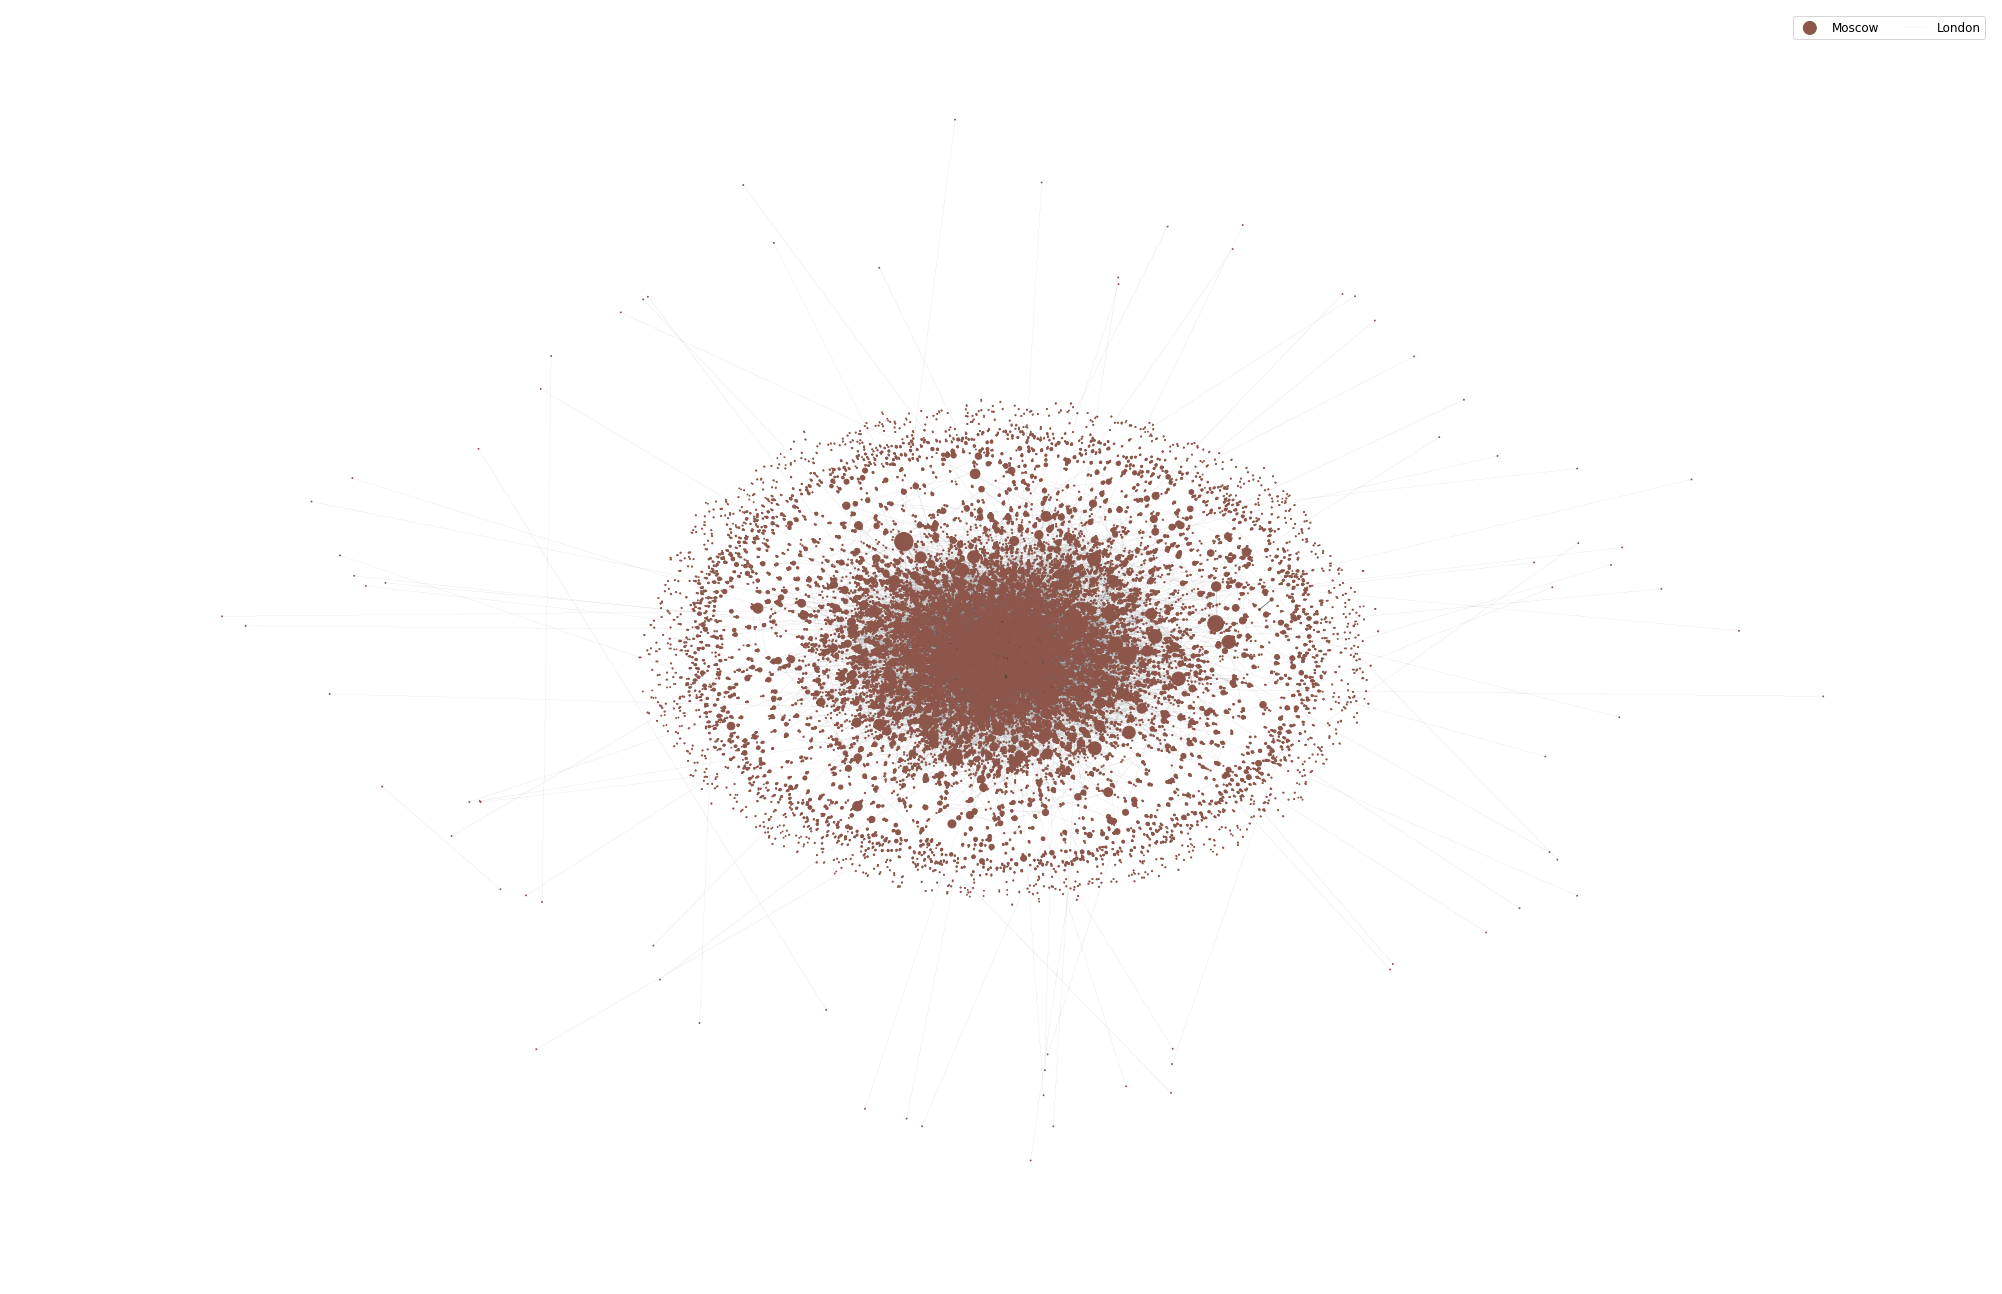

In [191]:
fig, ax = plt.subplots(figsize=(34.72,23.17))
d=G_withSentValue.degree()

net_drawing = nx.draw(G_withSentValue,pos=positions,width=0.04,node_size=[v[1] * 0.8 for v in d],node_color=node_color)

plt.legend(
           tuple(legend_city),
           scatterpoints=1,
           loc='upper right',
           ncol=2,
           fontsize=12)
#plt.savefig('Top10.png')
plt.show()

In [12]:
node_to_city_dict = dict()
for node in G_withSentValue.nodes(data=True):
    if node[1]:
        if node[0] not in node_to_city_dict:
            node_to_city_dict[node[0]] = node[1]['city']
    else:
        node_to_city_dict[node[0]] = 'outside'
        


In [47]:
citi_to_color_dict = dict()
for idx, city in enumerate(legend_city,start=0):
    citi_to_color_dict[city] = legend_col[idx]
citi_to_color_dict

{'Barcelona': (0.7372549019607844,
  0.7411764705882353,
  0.13333333333333333,
  1.0),
 'Belgrade': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058, 1.0),
 'Berlin': (1.0, 0.7333333333333333, 0.47058823529411764, 1.0),
 'Bucharest': (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
 'Budapest': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589, 1.0),
 'Hamburg': (0.5490196078431373,
  0.33725490196078434,
  0.29411764705882354,
  1.0),
 'Kharkiv': (0.7803921568627451, 0.7803921568627451, 0.7803921568627451, 1.0),
 'Kyiv': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 'London': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
 'Madrid': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 'Milan': (0.6196078431372549, 0.8549019607843137, 0.8980392156862745, 1.0),
 'Minsk': (0.7686274509803922, 0.611764705882353, 0.5803921568627451, 1.0),
 'Moscow': (0.12156862745098039, 0.4666666666666667, 0

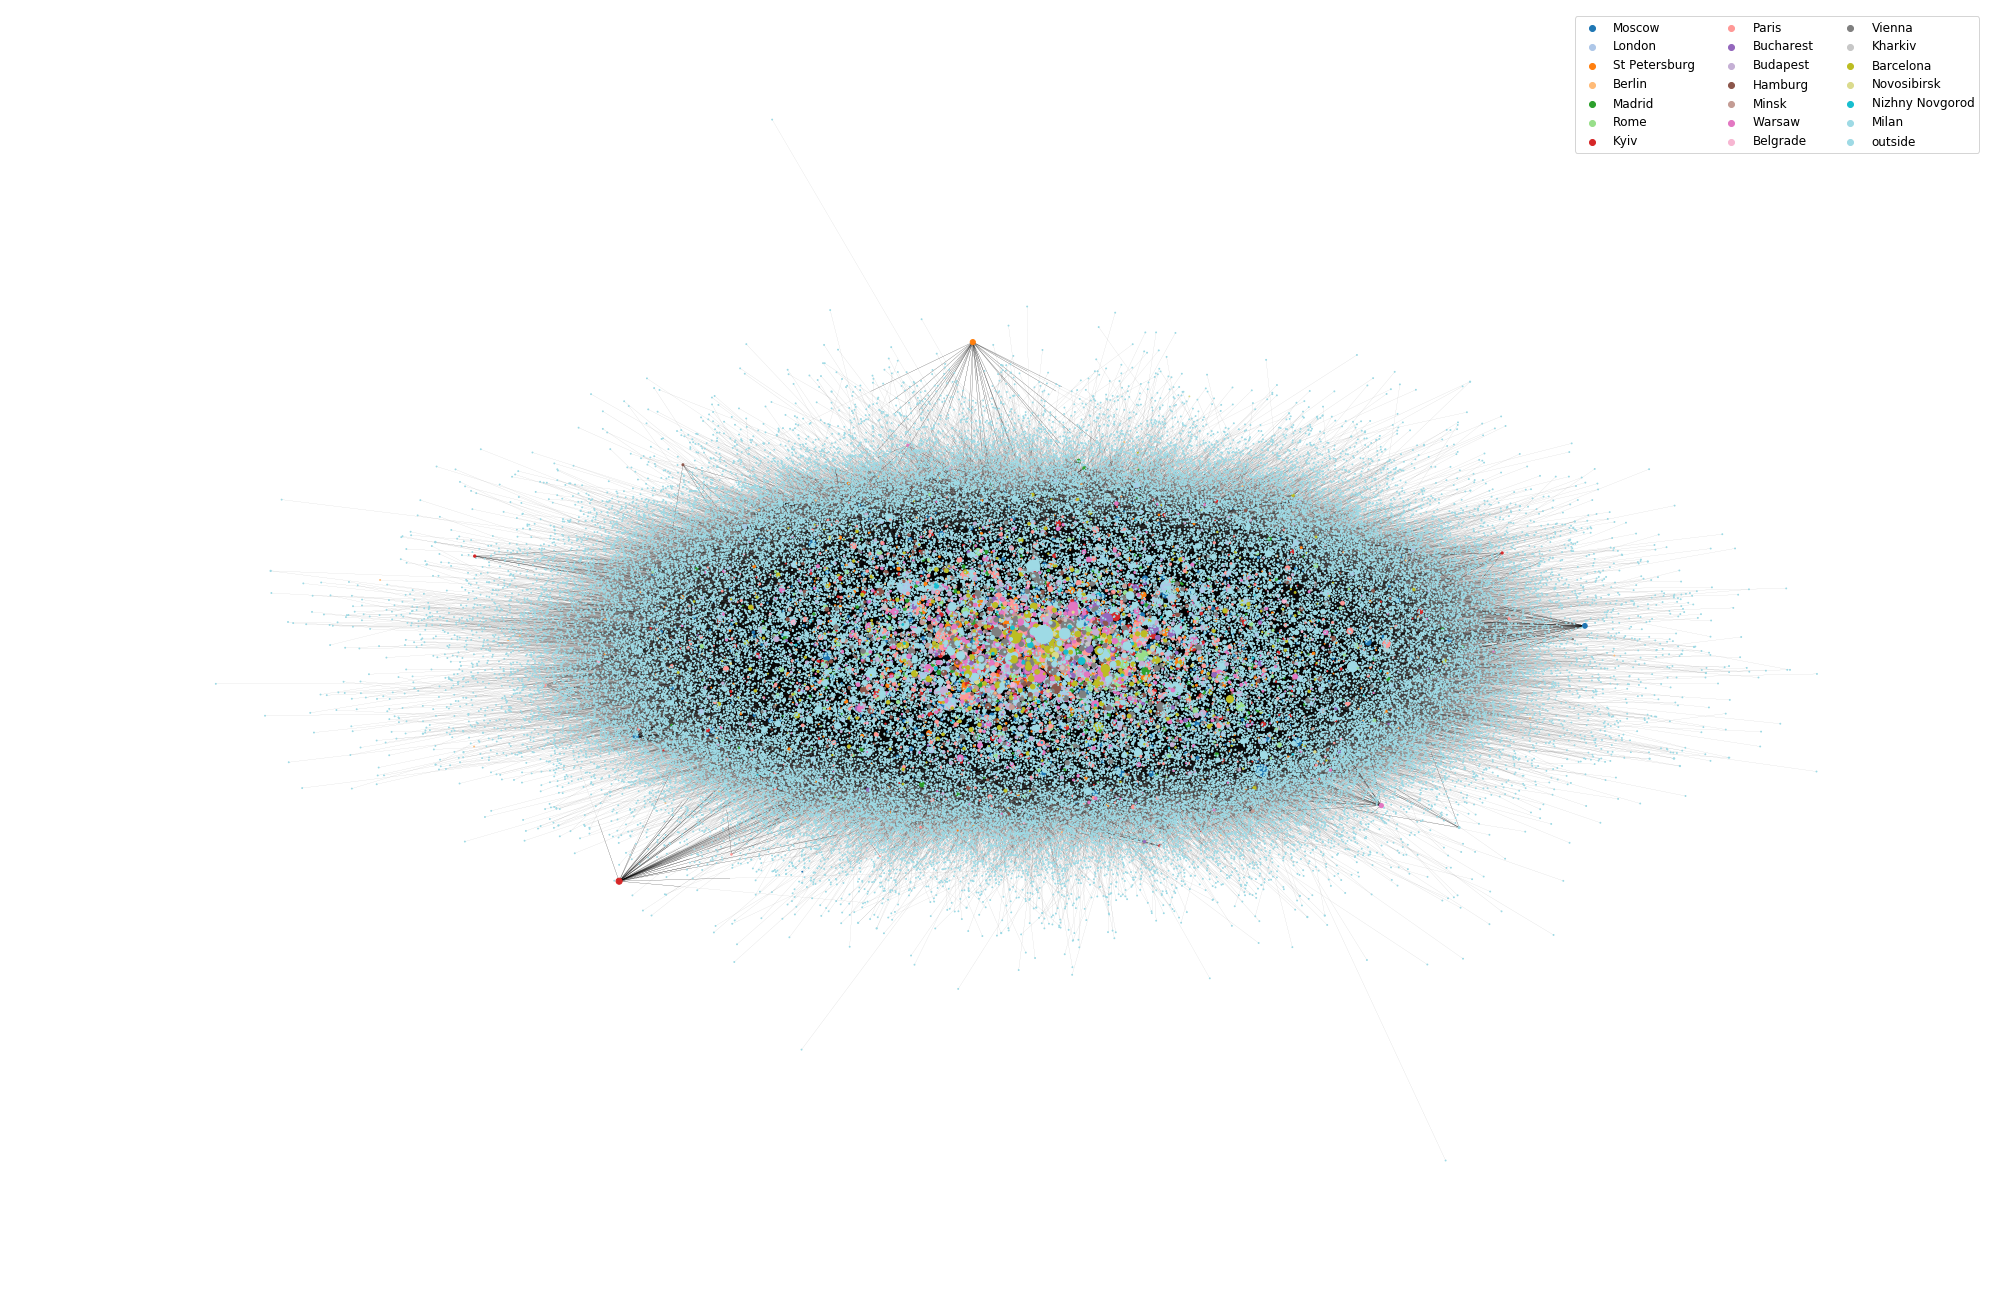

In [54]:
# Using a figure to use it as a parameter when calling nx.draw_networkx
f = plt.figure(figsize=(34.72,23.17))
ax = f.add_subplot(1,1,1)
for label in legend_city  :
    ax.scatter([0],[0],color=citi_to_color_dict[label],label=label)

# Just fixed the color map
nx.draw_networkx(G_withSentValue,pos=positions,with_labels = False, width=0.04,node_size=[v[1] * 0.8 for v in d]
                 ,node_color=[v for k,v in node_to_color_dict.items()],ax=ax, labels=None, label=None)

# Setting it to how it was looking before.                                                                                                              
plt.axis('off')

plt.legend(
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=12)
plt.show()

### 3.1.User

#### 3.1.1. Initial Analysis

#### 3.1.2. Alternative Construction


## 4. Basic Network Analysis

In [166]:
# validation of the data:
print('Number of all reviews: ',len(rev) )
userRevWithSentVal = rev.loc[ rev['sentimentValue'].notnull()]
print('Number of all reviews with sentiment: ',len(userRevWithSentVal))
print('Edges without sentiment: ', len(rev) - len(userRevWithSentVal) )
print('How many edges are unique ( from these with sentiment) ',len(G.edges),' / 87064  not unique ( no of revisits ): ===>', len(userRevWithSentVal) -  len(G.edges) )
print('Number of all reviews we are using for analysis: ',len(G_withSentValue.edges))

Number of all reviews:  96085
Number of all reviews with sentiment:  87064
Edges without sentiment:  9021
How many edges are unique ( from these with sentiment)  85759  / 87064  not unique ( no of revisits ): ===> 1305
Number of all reviews we are using for analysis:  87064


### 4.1. Degree Distribution:

### 4.2. Power-laws and Friendship Paradox:

In [ ]:
#5.Comparizon on loglog chart
plt.figure(figsize=(16, 8), dpi= 500)
#plt.bar(deg, cnt, width=0.80, color='b')
plt.loglog(deg,cnt, label='Total degree distribution')
plt.loglog(in_deg,in_cnt, label='In degree distribution')
plt.loglog(out_deg,out_cnt, label='Out degree distribution')
plt.legend()
#fig= facecolor='w', edgecolor='w')
out_axes = plt.gca()
out_axes.set_xlim([1,150])
out_axes.set_ylim([1,100000])
plt.title("CouchSurfing reviews network power law degree distribution in log-log scale")
plt.ylabel("Node's count")
plt.xlabel("Node's degree")
#ax.set_xticks([d + 0.4 for d in deg])
#ax.set_xticklabels(deg)
plt.savefig('CouchSurfing reviews network power law degree distribution.png' , dpi = 500)
plt.show()

### 4.3\. Centrality

In [8]:
# for visualization purposes:
def getColorfromCmap(val): 
    cmap = cm.get_cmap('tab20') 
    return cmap(val)

legend_city=[city['name'] for idx,city in cities.iterrows()]
legend_city.append('outside')
legend_col=[getColorfromCmap(idx/(len(legend_city)-1)) for idx,x in enumerate(legend_city)]


In [9]:

#Creating the graph G
G = nx.DiGraph()
links = []
user_id_unique=set(hosts['id'].tolist())
#G.add_nodes_from(user_id_unique)
G.add_nodes_from([(rows['id'],{'city':rows['city']}) for idx,rows in hosts.iterrows()])

G.add_edges_from([(rows['to'],rows['from'])for index,rows in rev[['to','from','relationshipType']].iterrows() if rows['relationshipType']=='host'])
G.add_edges_from([(rows['from'],rows['to'])for index,rows in rev[['to','from','relationshipType']].iterrows() if rows['relationshipType']=='surf'])




  Number of nodes with betweenness centrality equal to 0:  93400 



  Number of nodes with betweenness centrality bigger than 0:  1431 




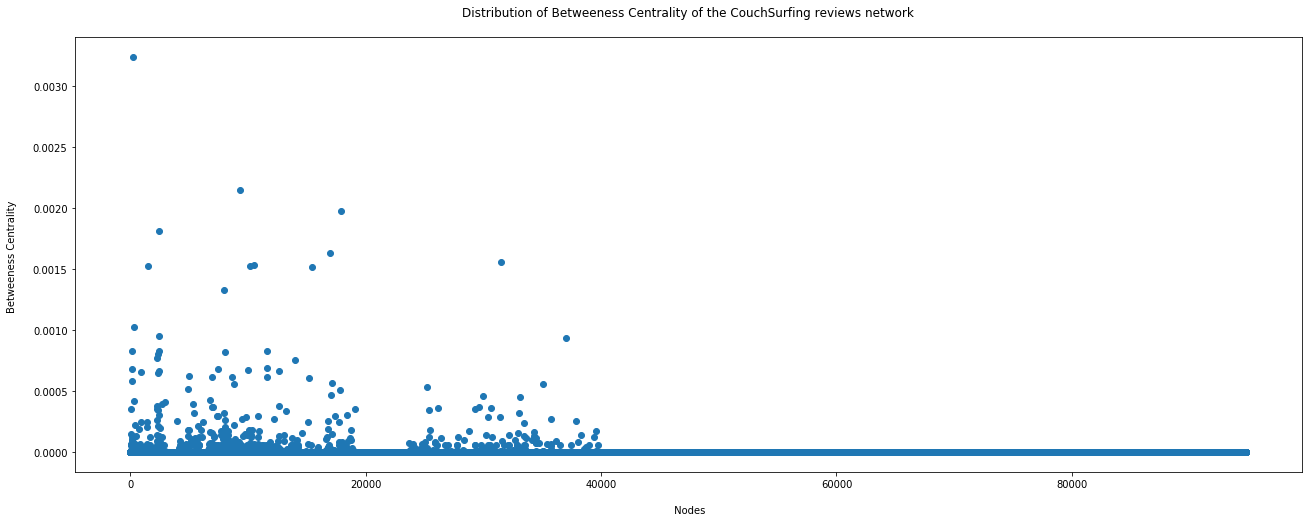

In [14]:
#plotting betweenness centrality of network

betweenness_centrality = nx.betweenness_centrality(G, k=1000)

no_bc_0 = list(betweenness_centrality.values()).count(0.0)
print("\n  Number of nodes with betweenness centrality equal to 0: ",no_bc_0,"\n\n")
print("\n  Number of nodes with betweenness centrality bigger than 0: ",len(list(betweenness_centrality.values()))-no_bc_0 ,"\n\n")

plt.figure(figsize = (22,8))
plt.plot(list(betweenness_centrality.values()),'o') 
plt.title("Distribution of Betweeness Centrality of the CouchSurfing reviews network\n")
plt.xlabel("\n Nodes")
plt.ylabel("Betweeness Centrality \n")
plt.show()

In [13]:
# calculation of the distribution of centrality by different cities:

node_to_city_dict = dict()
for node in G.nodes(data=True):
    if node[1]:
        if node[0] not in node_to_city_dict:
            node_to_city_dict[node[0]] = node[1]['city']
    else:
        node_to_city_dict[node[0]] = 'outside'
        
        

{2009059021: 0.0,
 2008295707: 0.0,
 2009276730: 0.0,
 2007438797: 0.0,
 2009017440: 0.0,
 2008873184: 0.0,
 2003698502: 0.0,
 2005423146: 0.0,
 2008461429: 0.0,
 2007897688: 0.0,
 1005318661: 0.0,
 2002963430: 0.0,
 2007156292: 0.0,
 2007603705: 0.0,
 2008732238: 0.0,
 2008182963: 0.0,
 1000754645: 0.0,
 2003021439: 2.931623570445139e-06,
 4308983: 0.0,
 3531747: 0.0,
 2000411067: 0.0,
 2000854741: 0.0,
 2008478484: 0.0,
 2009179593: 0.0,
 2009063624: 0.0,
 2007416721: 0.0,
 4935233: 0.0,
 2005146189: 7.170877798211131e-06,
 2007169164: 0.0,
 4196062: 0.0,
 2008850446: 0.0,
 2008606300: 0.0,
 2006253648: 0.0,
 2006551502: 8.43632682142486e-08,
 2006558767: 0.0,
 3918396: 6.001743506208669e-05,
 2004462182: 0.0,
 2002472636: 0.0,
 2007594801: 0.0,
 2001266184: 1.3076306573208532e-06,
 1002168816: 0.0,
 2004013575: 0.0,
 2001824984: 0.0,
 2001725408: 0.0,
 5491042: 0.0,
 1219678: 0.00035197568220965094,
 3763561: 3.0282898152739655e-06,
 2008014491: 0.0,
 2000196295: 0.0,
 2005517106: 0

### 4.4\. Assortativity: